In [24]:
# ======================================
# IMPORTS & CONFIGURATION
# ======================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from lmfit import Model

# Path to the big table you just made
INPUT_CSV = "../paper1/csv/combined_sources_all_spw_masked.csv"

# Minimum number of SPWs required for fitting
MIN_SPW_DETECTIONS = 4

# SPWs used in the catalog (must match column names)
SPW_ORDER = [15, 16, 17, 2, 3, 4, 5, 6, 8]

# Corresponding frequencies in MHz
SPW_FREQUENCIES_MHZ = {
    15: 1345.5883,
    16: 1409.5883,
    17: 1473.5883,
    2: 1653.5753,
    3: 1717.5753,
    4: 1781.57534,
    5: 1845.5753,
    6: 1909.5753,
    8: 2037.5753,
}

# Reference frequency for the model amplitude (MHz)
NU0_MHZ = 1400.0

# Flux cut applied on SPW16 (mJy)  -> Total_S_SPW16 > 10 mJy
FLUX_CUT_MJY = 10

# Alpha range filter
ALPHA_MIN, ALPHA_MAX = -3.0, 3.0

# Output figures
OUT_SINGLE = "../paper1/figs/spectral_index_histogram_single_gauss_Spw16gt10mJy.pdf"
OUT_TWO    = "../paper1/figs/spectral_index_histogram_two_gauss_Spw16gt10mJy.pdf"


# ======================================
# POWER-LAW MODEL FOR LMFIT
# IMPORTANT: nu0 must NOT be a parameter
# S(nu) = A * (nu/1400 MHz)^alpha
# => A == S_1400MHz
# ======================================

def powerlaw(nu, A, alpha):
    return A * (nu / NU0_MHZ) ** alpha

pl_model = Model(powerlaw, independent_vars=["nu"])


# ======================================
# LOAD BIG TABLE
# ======================================

df = pd.read_csv(INPUT_CSV)
df.columns = df.columns.str.strip()
print("Loaded table shape:", df.shape)


# ======================================
# COUNT SPW DETECTIONS PER SOURCE
# ======================================

def count_valid_spws(row, spw_list):
    """Count how many SPWs have a finite flux (wide table)."""
    count = 0
    for spw in spw_list:
        col = f"Total_S_SPW{spw}"
        if col in row.index and np.isfinite(row[col]):
            count += 1
    return count

df["N_SPW"] = df.apply(count_valid_spws, axis=1, spw_list=SPW_ORDER)

print("N_SPW counts:")
print(df["N_SPW"].value_counts().sort_index())


# ======================================
# FILTER SOURCES WITH ENOUGH SPWs
# ======================================

df_sel = df[df["N_SPW"] >= MIN_SPW_DETECTIONS].reset_index(drop=True)
print("Sources with enough detections:", len(df_sel))


# ======================================
# EXTRACT SPECTRA PER SOURCE
# ======================================

def extract_spectrum(row):
    """
    Extract frequency, flux, and flux error arrays
    from one row of the wide table.
    """
    freqs = []
    fluxes = []
    errors = []

    for spw in SPW_ORDER:
        flux_col = f"Total_S_SPW{spw}"
        err_col  = f"E_Total_S_SPW{spw}"

        if (flux_col not in row.index) or (err_col not in row.index):
            continue

        flux = row[flux_col]
        err  = row[err_col]

        if np.isfinite(flux) and np.isfinite(err) and (flux > 0) and (err > 0):
            freqs.append(SPW_FREQUENCIES_MHZ[spw])
            fluxes.append(flux)
            errors.append(err)

    return (np.array(freqs, dtype=float),
            np.array(fluxes, dtype=float),
            np.array(errors, dtype=float))


# ======================================
# FIT SPECTRAL INDICES WITH LMFIT ONLY
# ======================================

combined_results = []
fit_failed = 0

for _, row in df_sel.iterrows():

    freqs, fluxes, errors = extract_spectrum(row)

    # require at least MIN_SPW_DETECTIONS valid points
    if len(freqs) < MIN_SPW_DETECTIONS:
        continue

    params = pl_model.make_params(
        A=float(np.median(fluxes)),
        alpha=-0.7,
    )

    try:
        lmfit_result = pl_model.fit(
            fluxes,
            params,
            nu=freqs,
            weights=1.0 / errors,
            nan_policy="raise"
        )
    except Exception:
        fit_failed += 1
        continue

    alpha_lm   = lmfit_result.params["alpha"].value
    e_alpha_lm = lmfit_result.params["alpha"].stderr
    A_lm       = lmfit_result.params["A"].value
    e_A_lm     = lmfit_result.params["A"].stderr
    chi2_red   = lmfit_result.redchi

    combined_results.append({
        "Source_ID": row["Source_ID"],
        "N_SPW_used": int(len(freqs)),

        "alpha_lmfit": alpha_lm,
        "E_alpha_lmfit": e_alpha_lm,
        "A_lmfit": A_lm,         # == S_1400MHz (mJy, if your table is mJy)
        "E_A_lmfit": e_A_lm,
        "chi2_red_lmfit": chi2_red,
    })

alpha_all_df = pd.DataFrame(combined_results)
print("Total entries in alpha_all_df:", len(alpha_all_df))
print("Fits failed (skipped):", fit_failed)


# ======================================
# ATTACH SPW16 FLUX, THEN FILTER:
#   Total_S_SPW16 > 10 mJy  AND  -3 <= alpha <= 3
# ======================================

spw16_df = df_sel[["Source_ID", "Total_S_SPW16"]].copy()

alpha_all_df = alpha_all_df.merge(
    spw16_df,
    on="Source_ID",
    how="left"
).rename(columns={"Total_S_SPW16": "S_SPW16_mJy"})

mask = (
    np.isfinite(alpha_all_df["alpha_lmfit"]) &
    np.isfinite(alpha_all_df["S_SPW16_mJy"]) &
    (alpha_all_df["S_SPW16_mJy"] > FLUX_CUT_MJY) &
    (alpha_all_df["alpha_lmfit"] >= ALPHA_MIN) &
    (alpha_all_df["alpha_lmfit"] <= ALPHA_MAX)
)

alpha_good_lmfit = alpha_all_df[mask].reset_index(drop=True)

print(
    f"Sources kept after cuts: "
    f"S_SPW16 > {FLUX_CUT_MJY} mJy and {ALPHA_MIN}<=alpha<={ALPHA_MAX}:",
    len(alpha_good_lmfit)
)




Loaded table shape: (876, 50)
N_SPW counts:
N_SPW
1    218
2     51
3     39
4     30
5     31
6     26
7     30
8     37
9    414
Name: count, dtype: int64
Sources with enough detections: 568
Total entries in alpha_all_df: 568
Fits failed (skipped): 0
Sources kept after cuts: S_SPW16 > 10 mJy and -3.0<=alpha<=3.0: 140


✅ Saved: ../paper1/figs/spectral_index_histogram_single_gauss_Spw16gt10mJy.pdf
   Single Gaussian: mu=-0.821, sigma=0.453, N=140


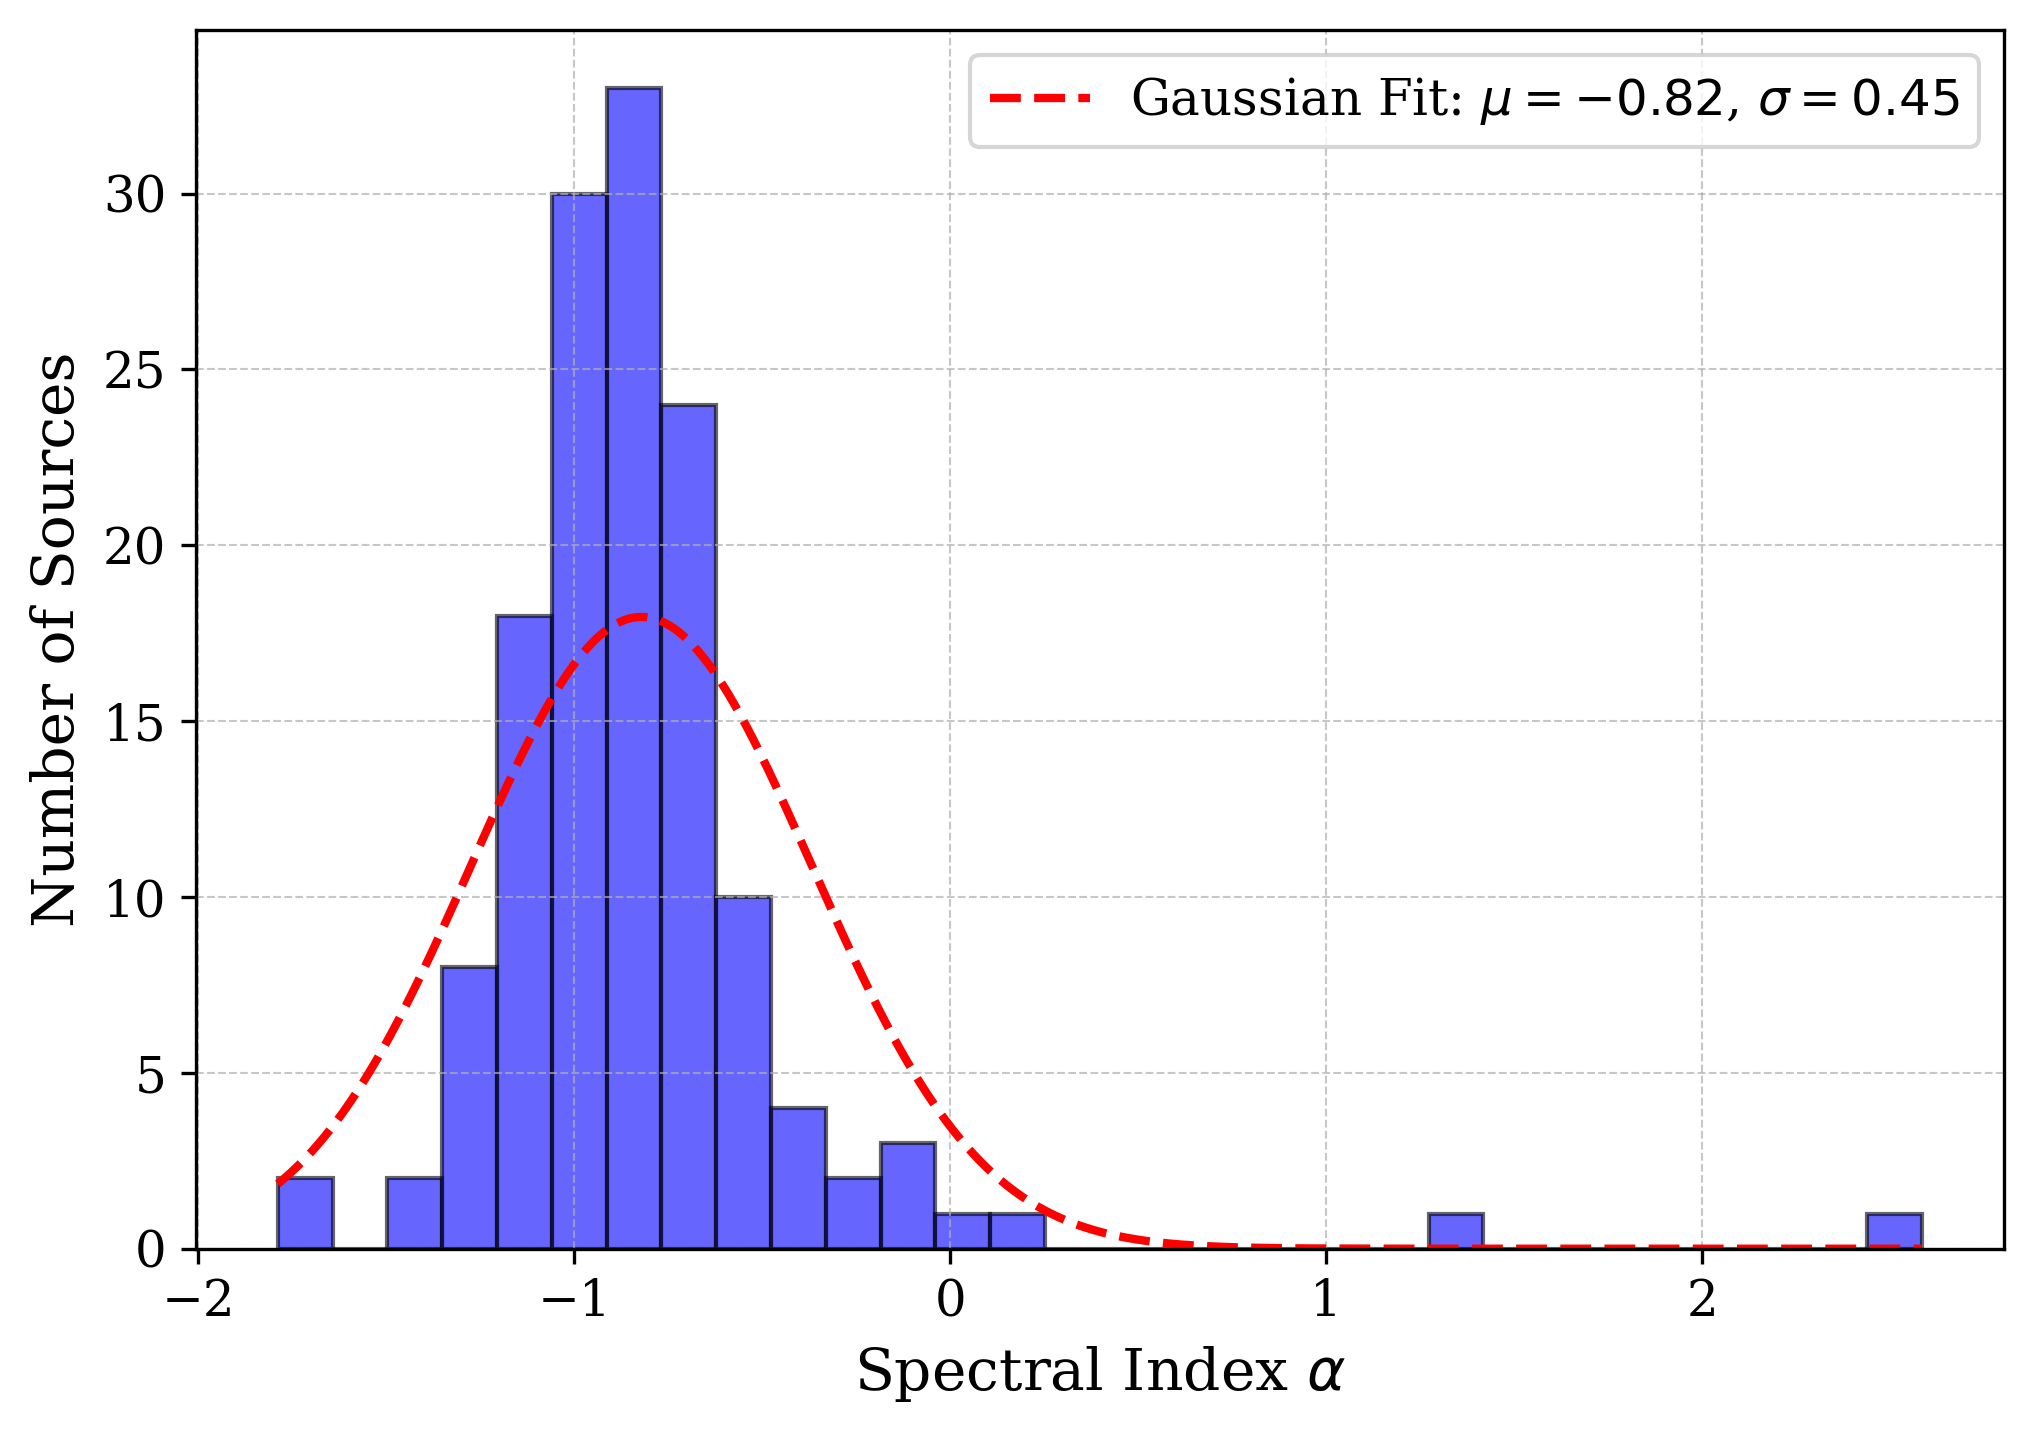

In [29]:
# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# HISTOGRAM 1: Single Gaussian fit
# ======================================

alpha_lm_good = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha_lm_good) == 0:
    raise ValueError("No alpha values left after filtering — check your flux units / cut.")

mu_lm, std_lm = norm.fit(alpha_lm_good)

fig, ax = plt.subplots(figsize=(7, 5))

counts, bins, _ = ax.hist(
    alpha_lm_good,
    bins=30,
    color='blue',
    edgecolor='black',
    alpha=0.6
)

bin_width = bins[1] - bins[0]
x = np.linspace(bins[0], bins[-1], 1000)
y = norm.pdf(x, mu_lm, std_lm) * len(alpha_lm_good) * bin_width

ax.plot(
    x, y,
    'r--',
    linewidth=2,
    label=fr'Gaussian Fit: $\mu={mu_lm:.2f}$, $\sigma={std_lm:.2f}$'
)

ax.set_xlabel(r'Spectral Index $\alpha$')
ax.set_ylabel('Number of Sources')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

plt.tight_layout()
os.makedirs(os.path.dirname(OUT_SINGLE), exist_ok=True)
plt.savefig(OUT_SINGLE, bbox_inches='tight')
print(f"✅ Saved: {OUT_SINGLE}")
print(f"   Single Gaussian: mu={mu_lm:.3f}, sigma={std_lm:.3f}, N={len(alpha_lm_good)}")
plt.show()

✅ Saved: ../paper1/figs/spectral_index_histogram_two_gauss_Spw16gt10mJy.pdf
Steep: mu=-0.885, sigma=0.225, A=33.5
Flat : mu=-0.116, sigma=0.300, A=1.7
Total sources (after cuts): 140


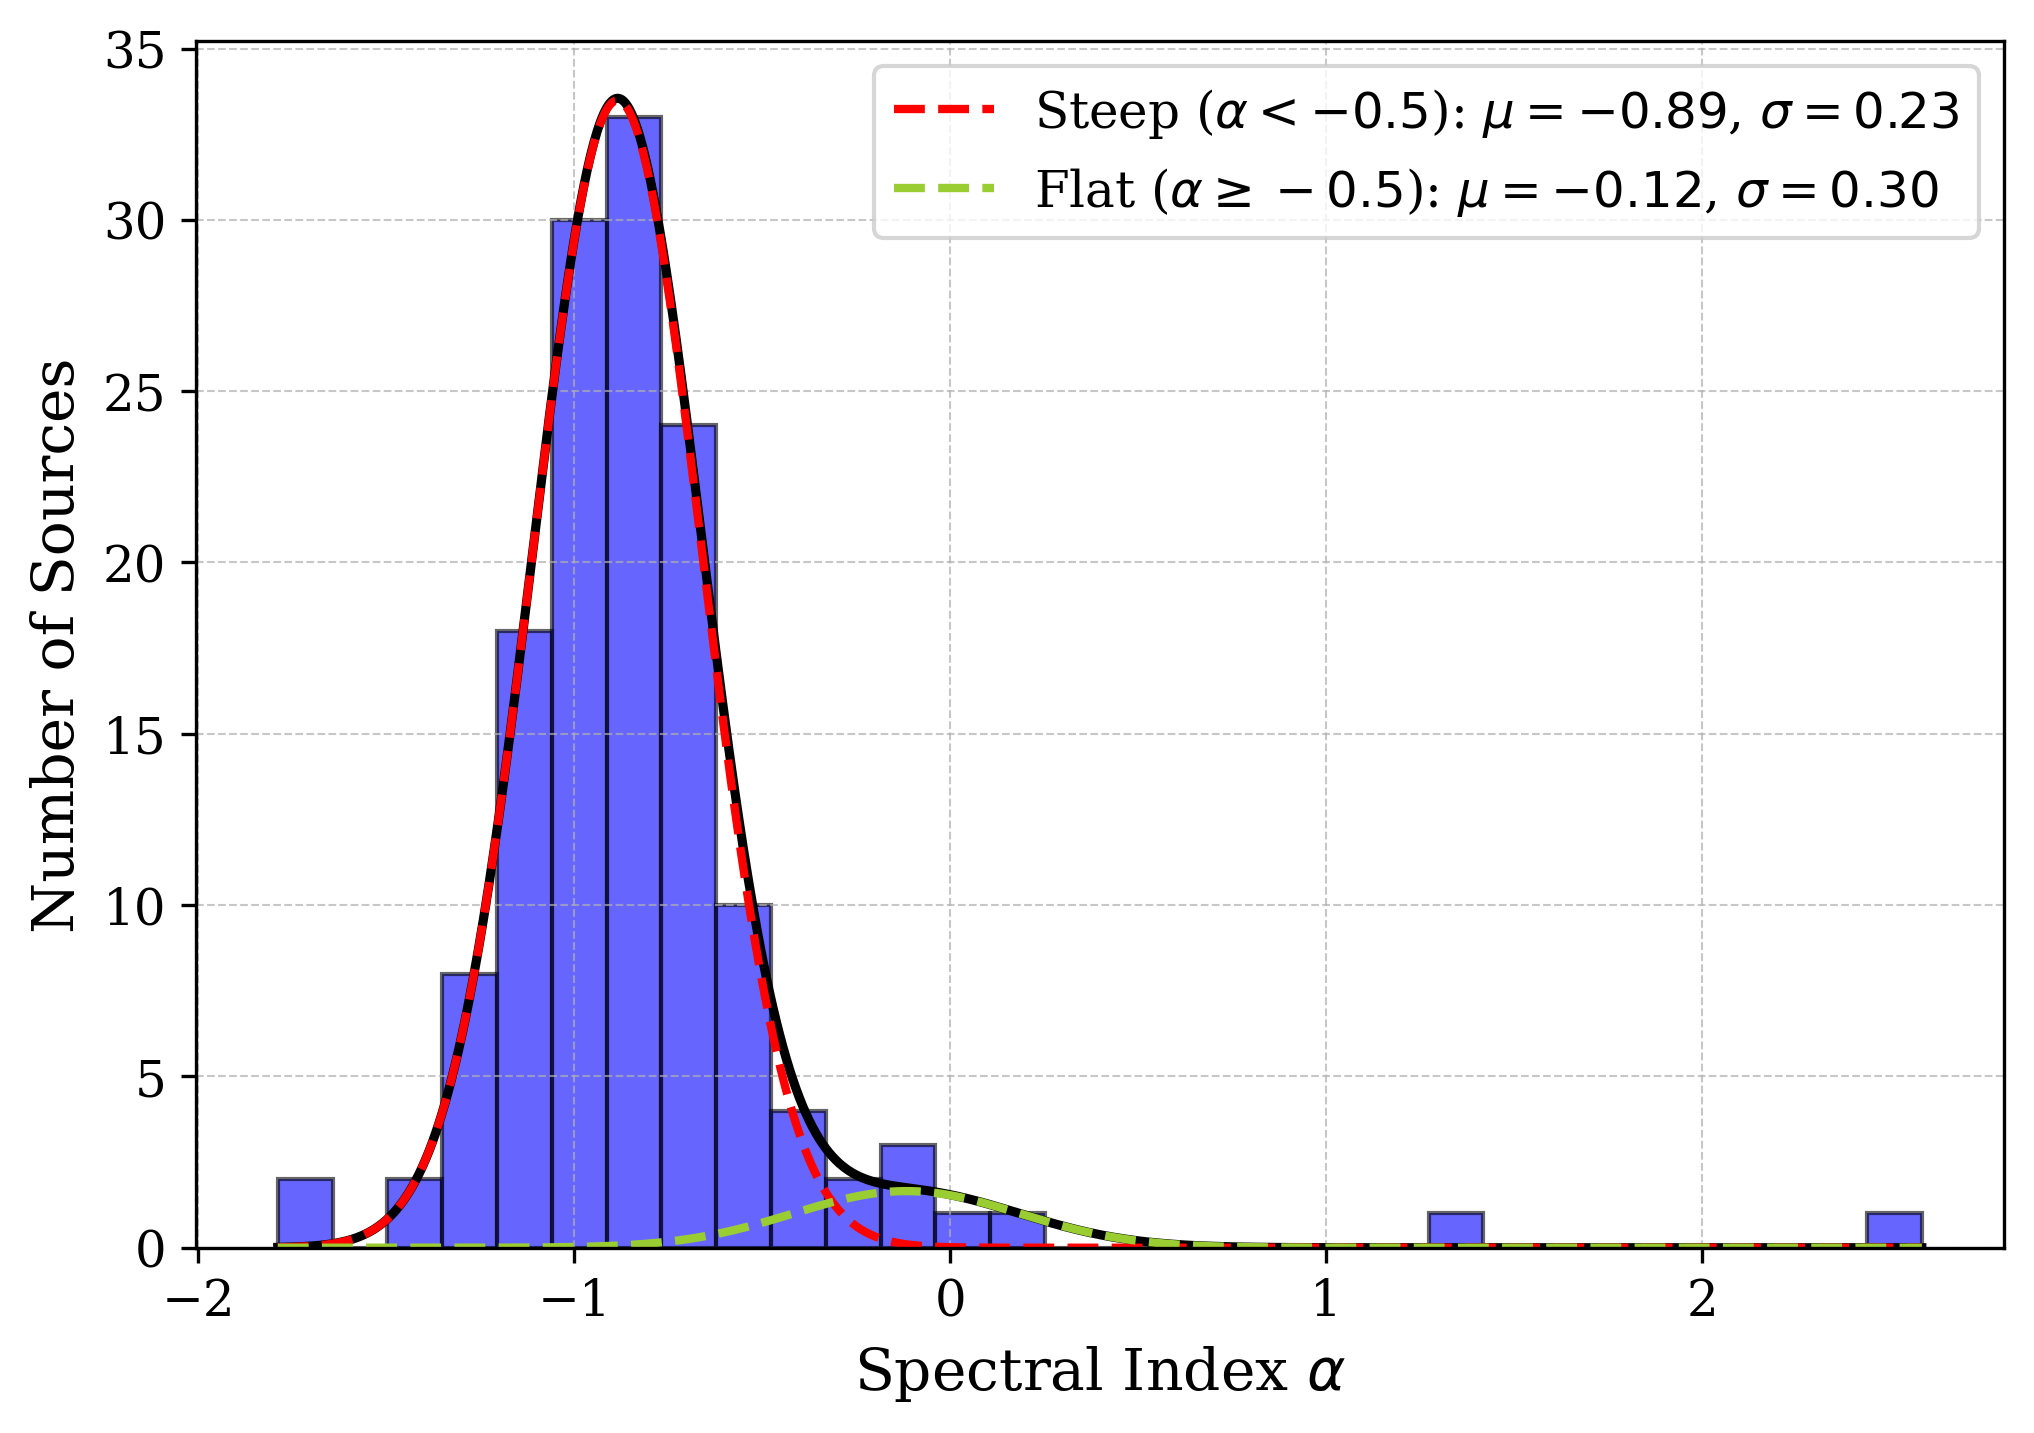

In [26]:
# ======================================
# HISTOGRAM 2: Two-Gaussian (steep + flat) fit
# ======================================

# Color-blind friendly LINE colors only (histogram color unchanged)
COL_TOTAL = 'black'
COL_STEEP = 'red'
COL_FLAT  = 'yellowgreen'

def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

fig, ax = plt.subplots(figsize=(7, 5))

counts, bins, _ = ax.hist(
    alpha_lm_good,
    bins=30,
    color='blue',
    edgecolor='black',
    alpha=0.6
)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# ---- 1) Fit STEEP component (central peak)
steep_region = (bin_centers > -1.6) & (bin_centers < -0.4)
x_steep = bin_centers[steep_region]
y_steep = counts[steep_region]

if y_steep.sum() <= 0:
    raise ValueError("Steep-region histogram has zero counts. Adjust steep_region bounds.")

mu0_steep = np.average(x_steep, weights=y_steep)
sigma0_steep = np.sqrt(np.average((x_steep - mu0_steep) ** 2, weights=y_steep))
A0_steep = y_steep.max()

p0_steep = [A0_steep, mu0_steep, max(sigma0_steep, 0.1)]
bounds_steep = ([0.0, -1.5, 0.05], [np.inf, -0.5, 0.4])

A1, mu1, sigma1 = curve_fit(
    gauss, x_steep, y_steep,
    p0=p0_steep,
    bounds=bounds_steep
)[0]

A1, mu1, sigma1 = float(A1), float(mu1), float(sigma1)
steep_model_bins = gauss(bin_centers, A1, mu1, sigma1)

# ---- 2) Fit FLAT component (residual tail)
residual = np.clip(counts - steep_model_bins, 0.0, None)

flat_region = (bin_centers > -0.8) & (bin_centers < 1.0)
x_flat = bin_centers[flat_region]
y_flat = residual[flat_region]

if y_flat.sum() > 0:
    mu0_flat = np.average(x_flat, weights=y_flat)
    sigma0_flat = np.sqrt(np.average((x_flat - mu0_flat) ** 2, weights=y_flat))
    A0_flat = y_flat.max()

    p0_flat = [A0_flat, mu0_flat, max(sigma0_flat, 0.3)]
    bounds_flat = ([0.0, -0.7, 0.3], [np.inf, 0.6, 1.2])

    A2, mu2, sigma2 = curve_fit(
        gauss, x_flat, y_flat,
        p0=p0_flat,
        bounds=bounds_flat
    )[0]

    A2, mu2, sigma2 = float(A2), float(mu2), float(sigma2)
else:
    A2, mu2, sigma2 = 0.0, 0.0, 1.0

# ---- Smooth curves for plotting
x = np.linspace(bins[0], bins[-1], 1000)
g1 = gauss(x, A1, mu1, sigma1)
g2 = gauss(x, A2, mu2, sigma2)
gtot = g1 + g2

ax.plot(x, gtot, color=COL_TOTAL, linewidth=2.2)
ax.plot(x, g1, linestyle='--', linewidth=2, color=COL_STEEP,
        label=fr'Steep ($\alpha < -0.5$): $\mu={mu1:.2f}$, $\sigma={sigma1:.2f}$')
ax.plot(x, g2, linestyle='--', linewidth=2, color=COL_FLAT,
        label=fr'Flat ($\alpha \geq -0.5$): $\mu={mu2:.2f}$, $\sigma={sigma2:.2f}$')

ax.set_xlabel(r'Spectral Index $\alpha$')
ax.set_ylabel('Number of Sources')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

plt.tight_layout()
os.makedirs(os.path.dirname(OUT_TWO), exist_ok=True)
plt.savefig(OUT_TWO, bbox_inches='tight')
print(f"✅ Saved: {OUT_TWO}")
print(f"Steep: mu={mu1:.3f}, sigma={sigma1:.3f}, A={A1:.1f}")
print(f"Flat : mu={mu2:.3f}, sigma={sigma2:.3f}, A={A2:.1f}")
print(f"Total sources (after cuts): {len(alpha_lm_good)}")
plt.show()


Points plotted (kept sources): 140


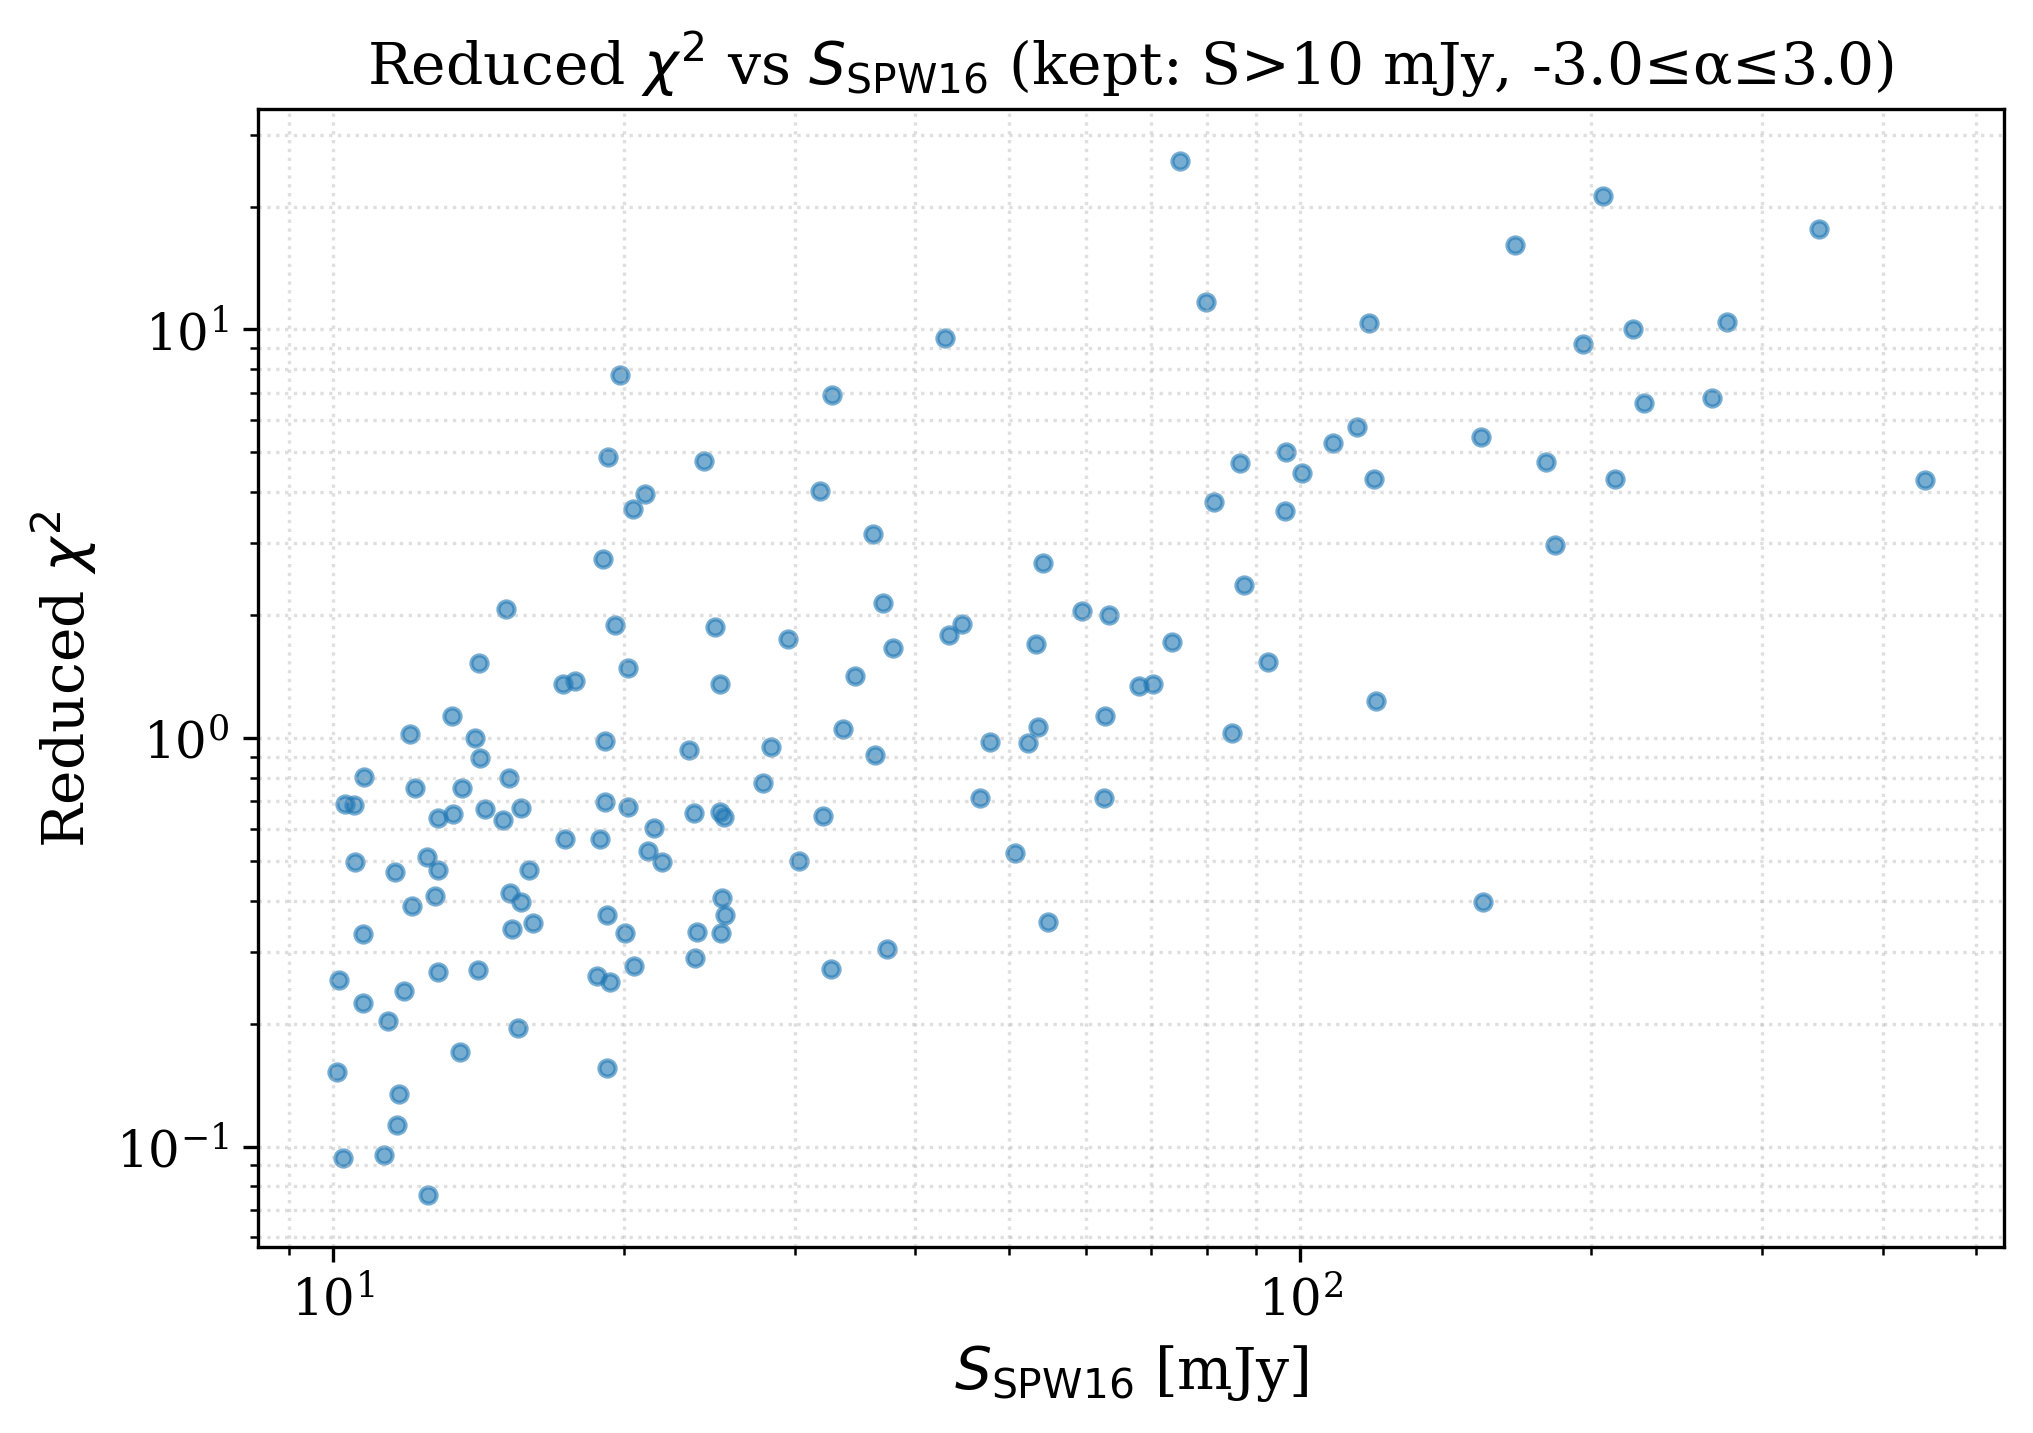

In [27]:
# ======================================
# PLOT: chi2_red vs SPW16 flux (KEPT SOURCES = alpha_good_lmfit)
# ======================================

plot_good = alpha_good_lmfit.copy()

mask_plot_good = (
    np.isfinite(plot_good["chi2_red_lmfit"]) &
    np.isfinite(plot_good["S_SPW16_mJy"]) &
    (plot_good["S_SPW16_mJy"] > 0) &
    (plot_good["chi2_red_lmfit"] > 0)
)
plot_good = plot_good[mask_plot_good].copy()

print("Points plotted (kept sources):", len(plot_good))

plt.figure(figsize=(7, 5))
plt.scatter(plot_good["S_SPW16_mJy"], plot_good["chi2_red_lmfit"], s=15, alpha=0.6)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$S_{\mathrm{SPW16}}$ [mJy]")
plt.ylabel(r"Reduced $\chi^2$")

plt.title(rf"Reduced $\chi^2$ vs $S_{{\mathrm{{SPW16}}}}$ (kept: S>{FLUX_CUT_MJY} mJy, {ALPHA_MIN}≤α≤{ALPHA_MAX})")
plt.grid(True, which="both", ls=":", alpha=0.4)

plt.tight_layout()
plt.show()
